In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<center>
<h1><b>Classification and Summarization with LLMs</b>
</center>

## Business Scenario

In this case study, we find ourselves in the role of data scientists at Apple. Our task is to support product managers in gathering feedback on MacBooks (and laptops in general) to enhance product design for the upcoming year. Our goal is to identify features to develop, retain, or phase out based on customer preferences. We aim to understand which features resonate with customers, identify areas for improvement, and address any concerns they may have. The primary sources of feedback are customer reviews on e-commerce platforms and YouTube reviews by influencers in the tech industry.

To achieve this objective, we will undertake the following steps:

1. Extract feedback from Amazon reviews and utilize aspect-based sentiment analysis to evaluate sentiment at a granular level, focusing on specific components such as the keyboard, CPU, etc. We will also gather insights about our product as well as competitors'.

2. Extract feedback from tech influencers on YouTube by analyzing transcripts of their videos. This analysis will help us distill key points from their reviews, highlighting what they liked, what they found lacking, and their expectations for future iterations of the product.

# Setup

In [1]:
!pip install -q openai==1.23.2 datasets tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 10.7 MB/s eta 0:00:00


# Authentication

In [11]:
!pip install -q  httpx==0.27.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.16.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [18]:
!pip uninstall numpy -y

Found existing installation: numpy 1.26.0
Uninstalling numpy-1.26.0:
  Successfully uninstalled numpy-1.26.0


In [19]:
# Install the necessary libraries
!pip install -q numpy==1.26.0 \
                httpx==0.27.2 \
                openai==1.23.2 \
                tiktoken==0.6.0 \
                datasets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.


In [20]:
!pip uninstall -y jax jaxlib thinc treescope pymc db-dtypes chex albumentations blosc2 imbalanced-learn scikit-image bigframes albucore xarray tensorflow

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: treescope 0.1.9
Uninstalling treescope-0.1.9:
  Successfully uninstalled treescope-0.1.9
Found existing installation: pymc 5.22.0
Uninstalling pymc-5.22.0:
  Successfully uninstalled pymc-5.22.0
Found existing installation: db-dtypes 1.4.3
Uninstalling db-dtypes-1.4.3:
  Successfully uninstalled db-dtypes-1.4.3
Found existing installation: chex 0.1.89
Uninstalling chex-0.1.89:
  Successfully uninstalled chex-0.1.89
Found existing installation: albumentations 2.0.7
Uninstalling albumentations-2.0.7:
  Successfully uninstalled albumentations-2.0.7
Found existing installation: blosc2 3.3.3
Uninstalling blosc2-3.3.3:
  Successfully uninstalled blosc2-3

In [7]:
!pip install -q \
numpy==1.26.0 \
httpx==0.27.2 \
openai==1.23.2 \
tiktoken==0.6.0 \
datasets

# Restart the runtime after installing libraries, other wise OpenAi client errors out with a Proxy error

In [42]:
# not required

# !pip install -q --no-cache-dir \
#     numpy==1.26.0 \
#     httpx==0.27.2 \
#     openai==1.23.2 \
#     tiktoken==0.6.0 \
#     datasets

In [25]:
!pip show datasets

Name: datasets
Version: 2.14.4
Summary: HuggingFace community-driven open-source library of datasets
Home-page: https://github.com/huggingface/datasets
Author: HuggingFace Inc.
Author-email: thomas@huggingface.co
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: aiohttp, dill, fsspec, huggingface-hub, multiprocess, numpy, packaging, pandas, pyarrow, pyyaml, requests, tqdm, xxhash
Required-by: torchtune


In [3]:
import pandas as pd
import numpy as np

from openai import OpenAI
from datasets import load_dataset
import tiktoken
import json
import random

from tqdm import tqdm
from datasets import load_dataset
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import os
from google.colab import userdata

os.environ['OPENAI_API_KEY']  = userdata.get('OPENAI_API_KEY')

api_key = os.environ['OPENAI_API_KEY']
#print(api_key)

# restart the runtime after installing libraries and before creating openai client
client = OpenAI(api_key=api_key)

In [ ]:
import os
print(os.environ.get('HTTP_PROXY'))
print(os.environ.get('HTTPS_PROXY'))
print(os.environ.get('ALL_PROXY'))

In [41]:
import httpx

try:
    httpx_client = httpx.Client()
    print("httpx client initialized successfully")
except TypeError as e:
    print(f"Error initializing httpx client: {e}")

httpx client initialized successfully


In [5]:
# Test the client after instantiating
import os
from openai import OpenAI

api_key = os.environ['OPENAI_API_KEY']
#print(api_key)

client = OpenAI(api_key=api_key)

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "user", "content": "Hello!"}
    ]
)

print(response.choices[0].message.content)


Hello! How can I assist you today?


We are going to choose the powerful gpt-3.5-turbo as our model for the following exercises.

In [7]:
model_name = 'gpt-3.5-turbo'

In [8]:
!pip show openai

Name: openai
Version: 1.23.2
Summary: The official Python library for the openai API
Home-page: https://github.com/openai/openai-python
Author: 
Author-email: OpenAI <support@openai.com>
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: anyio, distro, httpx, pydantic, sniffio, tqdm, typing-extensions
Required-by: 


## Utilities

Token counter to keep track of the completion window available in the prompt.

In [9]:
def num_tokens_from_messages(messages):

    """
    Return the number of tokens used by a list of messages.
    Adapted from the Open AI cookbook token counter
    """

    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    # Each message is sandwiched with <|start|>role and <|end|>
    # Hence, messages look like: <|start|>system or user or assistant{message}<|end|>

    tokens_per_message = 3 # token1:<|start|>, token2:system(or user or assistant), token3:<|end|>

    num_tokens = 0

    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            print("Value is: ", value)
            num_tokens += len(encoding.encode(value))
            #print("encoded numbers are: ", encoding.encode(value))
            print("Encoded numbers for {} are: {}".format(value, encoding.encode(value)))

            print(f"Encoded numbers for \033[1m{value}\033[0m are: {encoding.encode(value)}")

            print(f"Encoded numbers for '{value}' are: {encoding.encode(value)}")
            print(num_tokens)

    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>

    return num_tokens

In [10]:
zero_shot_prompt = [{'role':'system', 'content':'What is this'}]

In [11]:
num_tokens_from_messages(zero_shot_prompt)

Value is:  system
Encoded numbers for system are: [9125]
Encoded numbers for system are: [9125]
Encoded numbers for 'system' are: [9125]
4
Value is:  What is this
Encoded numbers for What is this are: [3923, 374, 420]
Encoded numbers for What is this are: [3923, 374, 420]
Encoded numbers for 'What is this' are: [3923, 374, 420]
7


10

# Auto-Label Classification

## Text $→$ Label generation

A Text $→$ label task (referred to henceforth as classification) involves the categorization of a given input text into a defined set of categories. There are three types of classification tasks:

1. Binary classification: Input text is classified into one of two classes (typically negations). Spam detection & sentiment analysis are examples of binary classification.
2. Multi-class classification: Input text is classified into one of more than two classes. Classifying a customer complaint as one of `critical`, `major` or `minor` is an example of multi-class classification (note that each input can be assigned only one class from the pool of defined classes).
3. Multi-label classification: Input text is classified into one or more labels. Assigning themes to legal documents, such as `Intellectual Property Law`, `Tax Law`, and `Employment Law`, is an example of multi-label classification (note that each input can be assigned multiple classes).


# Problem 1: Component Wise Product Review Analysis

In aspect-based sentiment analysis (ABSA), the aim is to identify the aspects of entities and the sentiment expressed for each aspect. The ultimate goal is to be able to generate a measure of polarity that explicitly accounts for the different aspects of the input. In this way, ABSA presents a nuanced version of the overall polarity of the sentiment expresses in the input. For effective ABSA, we should be able to generate appropriate themes and then assign sentiment to the portions of the input that correspond to this theme.

With respect to our business problem, this would be getting a sentiment for different aspects of the laptop like keyboard, display, performance etc. By recieving sentiment for each aspect instead of gathering overall sentiment, we can find out which aspects of the product are being well recieved and which are not.

### Step 1: Define objectives & Metrics

Unlike a sentiment where we assign positive or negative sentiment to a review, with ABSA we have to consider the additional objective of identifying entities (if any) present in the review.

To evaluate model performance, we judge the accuracy of the aspects + sentiment assignnment per aspect. Note that this is a much more stringent measure compared to the sentiment classification task we have seen so far. For example, if aspects identified by the LLM do not match the ground truth for a specific input, we count this prediction to be incorrect. A correct prediction is one where all the aspects are correctly idenfied and further the sentiment assignment for each aspect is also correctly identified (see figure below).

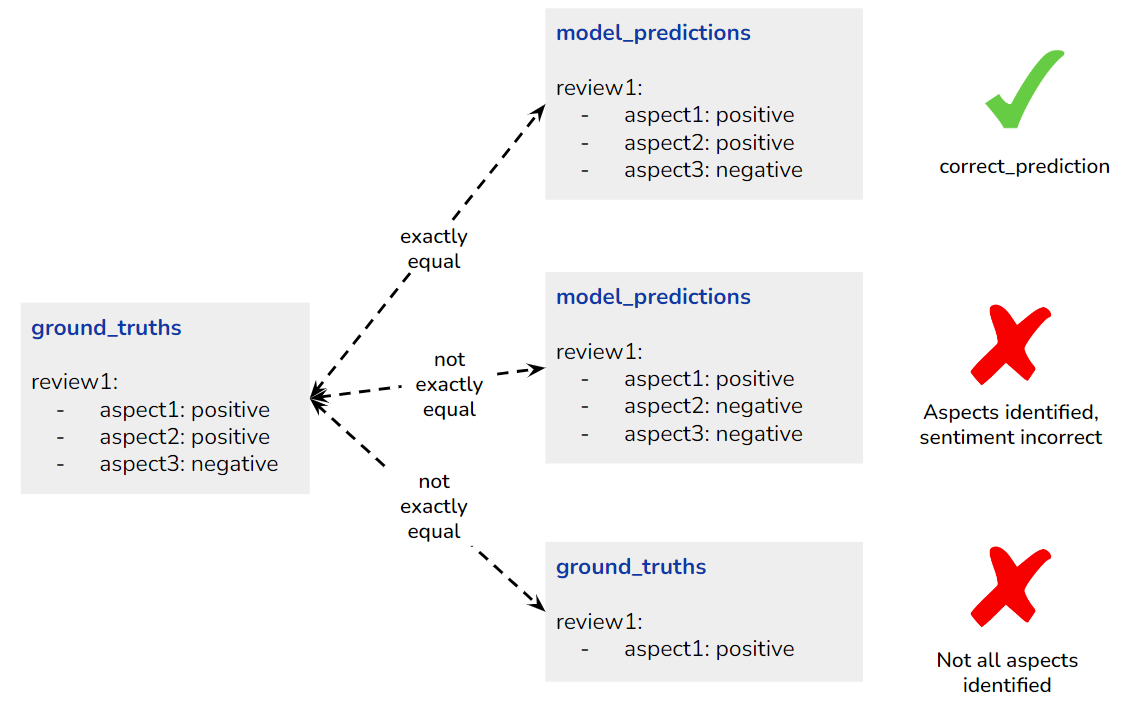

### Step 2: Assemble Data

In [20]:
!df -h /content/drive/

Filesystem      Size  Used Avail Use% Mounted on
drive           100G   11G   90G  11% /content/drive


In [21]:
custom_cache_path = "/content/drive/MyDrive/tmp/huggingface_datasets_cache"

if not os.path.exists(custom_cache_path):
    os.makedirs(custom_cache_path)

In [ ]:
from datasets import load_dataset
#from datasets.utils.file_utils import set_caching_enabled
from datasets import disable_caching

# Disable caching
disable_caching()

custom_cache_path = "/content/drive/MyDrive/tmp/huggingface_datasets_cache"

if not os.path.exists(custom_cache_path):
    os.makedirs(custom_cache_path)

try:
    ds = load_dataset("tomaarsen/setfit-absa-semeval-laptops",
                      cache_dir=custom_cache_path,
                     download_mode="force_redownload")
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Download failed: {e}")



# Load Train and Test data from .arrow files

In [29]:

from datasets import Dataset
import pandas as pd

dataset = Dataset.from_file('/content/drive/MyDrive/tmp/huggingface_datasets_cache/tomaarsen___setfit-absa-semeval-laptops/default/0.0.0/4474e2bd187176dc/setfit-absa-semeval-laptops-train.arrow')
df_train = dataset.to_pandas()

print(f"DataFrame shape: {df_train.shape}")
print(f"Columns: {df_train.columns.tolist()}")
print(df_train.head())


DataFrame shape: (2358, 4)
Columns: ['text', 'span', 'label', 'ordinal']
                                                text            span  \
0  I charge it at night and skip taking the cord ...            cord   
1  I charge it at night and skip taking the cord ...    battery life   
2  The tech guy then said the service center does...  service center   
3  The tech guy then said the service center does...    "sales" team   
4  The tech guy then said the service center does...        tech guy   

      label  ordinal  
0   neutral        0  
1  positive        0  
2  negative        0  
3  negative        0  
4   neutral        0  


In [35]:
dataset_test = Dataset.from_file('/content/drive/MyDrive/tmp/huggingface_datasets_cache/tomaarsen___setfit-absa-semeval-laptops/default/0.0.0/4474e2bd187176dc/setfit-absa-semeval-laptops-test.arrow')
df_test = dataset.to_pandas()

print(f"DataFrame shape: {df_test.shape}")
print(f"Columns: {df_test.columns.tolist()}")
print(df_test.head())

DataFrame shape: (2358, 4)
Columns: ['text', 'span', 'label', 'ordinal']
                                                text            span  \
0  I charge it at night and skip taking the cord ...            cord   
1  I charge it at night and skip taking the cord ...    battery life   
2  The tech guy then said the service center does...  service center   
3  The tech guy then said the service center does...    "sales" team   
4  The tech guy then said the service center does...        tech guy   

      label  ordinal  
0   neutral        0  
1  positive        0  
2  negative        0  
3  negative        0  
4   neutral        0  


# Load Train and Test from .parquet files downloaded directly from huggingface

In [34]:
import pandas as pd

# Read the parquet file
laptop_reviews_test_df = pd.read_parquet('/content/drive/MyDrive/Adv-Python/week13_GenAI/week13_MLS/Apple_ABSA_Data_files/test-00000-of-00001.parquet')
print(f"Shape: {laptop_reviews_test_df.shape}")
print(f"Columns: {laptop_reviews_test_df.columns.tolist()}")
print(laptop_reviews_test_df.head())

Shape: (654, 4)
Columns: ['text', 'span', 'label', 'ordinal']
                                                text                   span  \
0  Boot time is super fast, around anywhere from ...              Boot time   
1  tech support would not fix the problem unless ...           tech support   
2                                   Set up was easy.                 Set up   
3  Did not enjoy the new Windows 8 and touchscree...              Windows 8   
4  Did not enjoy the new Windows 8 and touchscree...  touchscreen functions   

  label  ordinal  
0              0  
1              0  
2              0  
3              0  
4              0  


In [33]:
# Read the parquet file
laptop_reviews_train_df = pd.read_parquet('/content/drive/MyDrive/Adv-Python/week13_GenAI/week13_MLS/Apple_ABSA_Data_files/train-00000-of-00001.parquet')
print(f"Shape: {laptop_reviews_train_df.shape}")
print(f"Columns: {laptop_reviews_train_df.columns.tolist()}")
print(laptop_reviews_train_df.head())

Shape: (2358, 4)
Columns: ['text', 'span', 'label', 'ordinal']
                                                text            span  \
0  I charge it at night and skip taking the cord ...            cord   
1  I charge it at night and skip taking the cord ...    battery life   
2  The tech guy then said the service center does...  service center   
3  The tech guy then said the service center does...    "sales" team   
4  The tech guy then said the service center does...        tech guy   

      label  ordinal  
0   neutral        0  
1  positive        0  
2  negative        0  
3  negative        0  
4   neutral        0  


In [ ]:
#aspect_based_laptop_corpus = load_dataset("tomaarsen/setfit-absa-semeval-laptops")

In [ ]:
#aspect_based_laptop_corpus

In [ ]:
#aspect_based_laptop_corpus.shape

In [ ]:
#laptop_reviews_train_df = aspect_based_laptop_corpus['train'].to_pandas()

We carve out two sections of the data - one for examples and another for gold examples. We use the gold examples data to test our prompts later while we use the examples to create our few-shot prompt.

In [36]:
laptop_reviews_train_df.sample(10)

,text,span,label,ordinal
2243,"The feel of this is better than the Toshiba, too.",feel,positive,0
238,Additional caveat: the base installation comes...,base installation,negative,0
2072,"However, I love this particular Mac because it...",lighted keyboard,positive,0
145,"I can render AVCHD movies with little effort, ...",quad core I7,positive,0
1573,It took several weeks just to get them to ackn...,warranty,negative,0
1871,) And printing from either word processor is a...,word processor,negative,0
2165,The first one sent: Touchpad didn't work The s...,Touchpad,negative,0
903,"It did fairly well, other than it's poor perfo...",performance,negative,0
1926,But sitting on a lap or on a desk in front of ...,external keyboard,neutral,0
1741,I dual boot with Linux and that other security...,Linux,neutral,0


In [37]:
laptop_reviews_train_df.label.unique()

array(['neutral', 'positive', 'negative', 'conflict'], dtype=object)

## Let's remove conflict from the labels as we are only concerned with the three sentiments.

In [38]:
laptop_reviews_train_df.label.nunique()

4

In [39]:
laptop_reviews_train_df = laptop_reviews_train_df[laptop_reviews_train_df['label']!='conflict']

In [40]:
laptop_reviews_train_df['id'] = laptop_reviews_train_df.index

In this dataset, the column span refers to the aspect being discussed in the review. Let's check the number of unique aspects discussed in the reviews.

In [41]:
laptop_reviews_train_df

,text,span,label,ordinal,id
0,I charge it at night and skip taking the cord ...,cord,neutral,0,0
1,I charge it at night and skip taking the cord ...,battery life,positive,0,1
2,The tech guy then said the service center does...,service center,negative,0,2
3,The tech guy then said the service center does...,"""sales"" team",negative,0,3
4,The tech guy then said the service center does...,tech guy,neutral,0,4
...,...,...,...,...,...
2352,We also use Paralles so we can run virtual mac...,Windows 7 Home Premium,neutral,0,2352
2353,We also use Paralles so we can run virtual mac...,Windows Server Enterprise 2003,neutral,0,2353
2354,We also use Paralles so we can run virtual mac...,Windows Server 2008 Enterprise,neutral,0,2354
2356,"How Toshiba handles the repair seems to vary, ...",repair,positive,1,2356


In [42]:
laptop_reviews_train_df.span.unique()

array(['cord', 'battery life', 'service center', ...,
       'Windows Server Enterprise 2003', 'Windows Server 2008 Enterprise',
       'repair'], dtype=object)

In [43]:
laptop_reviews_train_df.span.nunique()

1031

In [44]:
laptop_reviews_train_df.loc[:, 'span'] = laptop_reviews_train_df['span'].str.lower()

In [45]:
laptop_reviews_train_df.span.nunique()

945

In [46]:
laptop_reviews_train_df.head()

,text,span,label,ordinal,id
0,I charge it at night and skip taking the cord ...,cord,neutral,0,0
1,I charge it at night and skip taking the cord ...,battery life,positive,0,1
2,The tech guy then said the service center does...,service center,negative,0,2
3,The tech guy then said the service center does...,"""sales"" team",negative,0,3
4,The tech guy then said the service center does...,tech guy,neutral,0,4


There are way too many aspects. Most of them are infrequent and are useless for the business. Let's focus on top 6 aspects based on the frequency of the aspect. To do that let's check the top most frequent aspects.

In [47]:
laptop_reviews_train_df.span.value_counts()[:15]

,count
span,
screen,60
price,56
use,53
battery life,52
keyboard,50
battery,47
programs,37
features,35
software,33


We will focus on the following six aspects of the Laptops. These are among the most frequent and are important for the design decisions.

1. Screen
2. Price
3. Battery Life
4. Keyboard
5. Programs
6. Warranty
    
To do this, let's filter our dataset to contain only these aspects.

In [48]:
aspects = ['screen', 'price', 'battery life', 'keyboard', 'programs', 'warranty']
laptop_reviews_train_df = laptop_reviews_train_df[laptop_reviews_train_df['span'].isin(aspects)]

In [49]:
laptop_reviews_train_df.span.unique()

array(['battery life', 'screen', 'price', 'warranty', 'keyboard',
       'programs'], dtype=object)

In [50]:
laptop_reviews_train_df.shape

(286, 5)

Let's rename the column to aspect

In [51]:
laptop_reviews_train_df = laptop_reviews_train_df.rename(columns={'span': 'aspect'})

In [52]:
laptop_reviews_examples_df, laptop_reviews_gold_examples_df = train_test_split(
    laptop_reviews_train_df, #<- the full dataset
    test_size=0.2, #<- 50% random sample selected for gold examples
    random_state=42 #<- ensures that the splits are the same for every session
)

In [54]:
laptop_reviews_examples_df.shape

(228, 5)

In [55]:
laptop_reviews_examples_df.columns

Index(['text', 'aspect', 'label', 'ordinal', 'id'], dtype='object')

In [53]:
laptop_reviews_gold_examples_df.shape

(58, 5)

To create this index, we start with a dictionary of aspects in  the task

In [56]:
columns_to_select = [ 'text', 'aspect', 'label']

In [57]:
gold_examples = json.loads((
        laptop_reviews_gold_examples_df.loc[:, columns_to_select]
                                           .sample(30, random_state=42) #<- ensures that gold examples are the same for every session
                                           .to_json(orient='records')
))

In [60]:
len(gold_examples)

30

In [58]:
gold_examples[0]

{'text': "It has a 10 hour battery life when you're doing web browsing and word editing, making it perfect for the classroom or office, and in terms of gaming and movie playing it'll have a battery life of just over 5 hours.",
 'aspect': 'battery life',
 'label': 'positive'}

### Step 3: Derive Prompt

Now that we have done the preprocessing let's create zero-shot and few-shot prompts for our ABSA.

#### Create prompts

In [61]:
user_message_template = """```{laptop_review}```"""

**Zero-shot prompt**

Let's start with a zero shot prompt for ABSA. Later, we will explore few-shot prompt.

In [62]:
zero_shot_system_message = """
Perform aspect based sentiment analysis on laptop reviews presented in the input delimited by triple backticks, that is, ```.
In each review there might be one or more of the following aspects: 'battery life', 'screen', 'keyboard', 'price', 'warranty','programs'.
For each review presented as input:
- Identify if there are any of the 6 aspects ('battery life', 'screen', 'keyboard', 'price', 'warranty', 'programs') present in the review.
- Assign a sentiment polarity (positive, negative or neutral) for each aspect

Arrange your response a JSON object with the following headers:
- category:[list of aspects]
- polarity:[list of corresponding polarities for each aspect]}
write the whole sentiment - positive, negative or neutral and not just p,n
"""

In [63]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

In [64]:
num_tokens_from_messages(zero_shot_prompt)

Value is:  system
Encoded numbers for system are: [9125]
Encoded numbers for system are: [9125]
Encoded numbers for 'system' are: [9125]
4
Value is:  
Perform aspect based sentiment analysis on laptop reviews presented in the input delimited by triple backticks, that is, ```.
In each review there might be one or more of the following aspects: 'battery life', 'screen', 'keyboard', 'price', 'warranty','programs'.
For each review presented as input:
- Identify if there are any of the 6 aspects ('battery life', 'screen', 'keyboard', 'price', 'warranty', 'programs') present in the review.
- Assign a sentiment polarity (positive, negative or neutral) for each aspect

Arrange your response a JSON object with the following headers:
- category:[list of aspects]
- polarity:[list of corresponding polarities for each aspect]}
write the whole sentiment - positive, negative or neutral and not just p,n

Encoded numbers for 
Perform aspect based sentiment analysis on laptop reviews presented in the in

169

Let's create the few-shot prompt right now before evaluating the zero-shot so that we can evaluate zero-shot and few-shot together.

**Few-shot prompt**

The system prompt stays the same as the zero-shot. We are only going to add few examples on top of the system prompt to create the few-shot prompt.

## Hard coded few_shot_prompt

In [68]:

# few_shot_system_message_2 = """
# You are an expert at aspect-based sentiment analysis for laptop reviews.

# TASK: Analyze laptop reviews to identify specific aspects and their associated sentiments.

# TARGET ASPECTS: Only analyze these 6 aspects when present in the review:
# 1. 'battery life' - battery performance, duration, charging
# 2. 'screen' - display quality, resolution, brightness, size
# 3. 'keyboard' - typing experience, key feel, layout
# 4. 'price' - cost, value, affordability, pricing
# 5. 'warranty' - warranty coverage, support, service
# 6. 'programs' - software, applications, pre-installed programs

# SENTIMENT LABELS:
# - positive: clearly favorable opinion
# - negative: clearly unfavorable opinion
# - neutral: mixed, moderate, or factual statement without clear sentiment

# INSTRUCTIONS:
# 1. Read the laptop review enclosed in triple backticks (```)
# 2. Identify which of the 6 target aspects are mentioned or clearly implied
# 3. Determine the sentiment for each identified aspect
# 4. Return results as a JSON array of objects

# OUTPUT FORMAT:
# [
#   {
#     "category": "[exact aspect name from the 6 categories]",
#     "sentiment": "[positive/negative/neutral]"
#   }
# ]

# EXAMPLES:

# Review: ```This laptop has terrible battery life, it only lasts 2 hours. However, the screen is crystal clear and vibrant.```
# Response: [
#   {
#     "category": "battery life",
#     "sentiment": "negative"
#   },
#   {
#     "category": "screen",
#     "sentiment": "positive"
#   }
# ]

# Review: ```For $800, this is a decent machine. The keyboard is comfortable for long typing sessions.```
# Response: [
#   {
#     "category": "price",
#     "sentiment": "positive"
#   },
#   {
#     "category": "keyboard",
#     "sentiment": "positive"
#   }
# ]

# Review: ```The warranty is standard - nothing special but covers the basics.```
# Response: [
#   {
#     "category": "warranty",
#     "sentiment": "neutral"
#   }
# ]

# Review: ```Great laptop overall, very satisfied with my purchase.```
# Response: []

# Now analyze the following review:
# """

## Dynamically generate few_shot_prompt

In [67]:
few_shot_system_message = """
Perform aspect based sentiment analysis on laptop reviews presented in the input delimited by triple backticks, that is, ```.
In each review there might be one or more of the following aspects: 'battery life', 'screen', 'keyboard', 'price', 'warranty','programs'.
For each review presented as input:
- Identify if there are any of the 6 aspects ('battery life', 'screen', 'keyboard', 'price', 'warranty', 'programs') present in the review.
- Assign a sentiment polarity (positive, negative or neutral) for each aspect

Arrange your response a JSON object with the following headers:
{
- category:[aspect]
- sentiment:[Sentiment for aspect]}
"""

Let us now look at how we can assemble examples to go along with this few-shot system message and compose a few-shot prompt.

Let's create a function that create examples for each of the selected aspects so that we have examples representign each of the aspects.

In [66]:
def create_examples(dataset, n=2):
    # Define the columns to select from the dataset
    columns_to_select = ['id', 'text','aspect', 'label']

    # Initialize an empty list to store the ids of the examples
    example_ids = []

    # Initialize a dictionary to store the ids of the examples for each aspect
    aspect_index = {
        'battery life': [],
        'screen': [],
        'keyboard': [],
        'price': [],
        'warranty': [],
        'programs': []
    }

    # Loop over the dataset
    for id, aspect in zip(dataset.id, dataset.aspect.str.lower()):
        # For each aspect in the aspect_index dictionary
        for key in aspect_index.keys():
            # If the aspect is in the current row's aspect
            if key in aspect:
                # Append the id of the row to the corresponding aspect in the aspect_index dictionary
                aspect_index[key].append(id)

    # For each aspect in the aspect_index dictionary
    for key in aspect_index:
        # Randomly select 'n' ids from the aspect's list and add them to the example_ids list
        example_ids.extend(np.random.choice(aspect_index[key], n).tolist())

    # Select the rows from the dataset that have their ids in the example_ids list
    examples = dataset.loc[dataset.id.isin(example_ids), columns_to_select]

    # Return the examples as a JSON string
    return examples.to_json(orient='records')

Now, let's create a function that will automatically create a prompt from th system prompt and the examples we have created. We must make sure that the examples are evenly distributed. If they are not evenly distributed, the model might be biased to pick the statements or aspects that are most frequent or the ones that are at the end of the prompt.

In [69]:
def create_prompt(system_message, examples, user_message_template):
    few_shot_prompt = [{'role':'system', 'content': system_message}]

    # Add examples to the prompt after formating them.
    for example in json.loads(examples):
        example_input = example['text']
        example_absa = example['aspect']
        example_label = example['label']

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    laptop_review=example_input
                )
            }
        )

        few_shot_prompt.append(
            {
                'role': 'assistant',
                'content': json.dumps({
                    "category": [example_absa],
                    "polarity": [example_label]
                })
            }
        )

    return few_shot_prompt

In [70]:
examples = create_examples(laptop_reviews_train_df)
few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)

Let's have a look at the examples and few-shot prompt we have createed.

In [71]:
examples

'[{"id":120,"text":"The battery life seems to be very good, and have had no issues with it.","aspect":"battery life","label":"positive"},{"id":183,"text":"My favorite part of this computer is that it has a vga port so I can connect it to a bigger screen.","aspect":"screen","label":"neutral"},{"id":456,"text":"The battery life was shorter than expected.","aspect":"battery life","label":"negative"},{"id":635,"text":"The graphics were awful and the warranty isn\'t even worth the cheap payment on the computer.","aspect":"warranty","label":"negative"},{"id":681,"text":"I like those programs better than Office and you can save your files to be completely compatible with the Office programs as well.","aspect":"programs","label":"positive"},{"id":938,"text":"At first, the computer seemed a great deal--seemingly high-end specs for a low, low price.","aspect":"price","label":"positive"},{"id":1136,"text":"For the same price, you get a lot more in the Asus....1920x1080 res.","aspect":"price","lab

In [72]:
few_shot_prompt

[{'role': 'system',
  'content': "\nPerform aspect based sentiment analysis on laptop reviews presented in the input delimited by triple backticks, that is, ```.\nIn each review there might be one or more of the following aspects: 'battery life', 'screen', 'keyboard', 'price', 'warranty','programs'.\nFor each review presented as input:\n- Identify if there are any of the 6 aspects ('battery life', 'screen', 'keyboard', 'price', 'warranty', 'programs') present in the review.\n- Assign a sentiment polarity (positive, negative or neutral) for each aspect\n\nArrange your response a JSON object with the following headers:\n{\n- category:[aspect]\n- sentiment:[Sentiment for aspect]}\n"},
 {'role': 'user',
  'content': '```The battery life seems to be very good, and have had no issues with it.```'},
 {'role': 'assistant',
  'content': '{"category": ["battery life"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': '```My favorite part of this computer is that it has a vga port so I

Now that we have both the zero-shot and few-shot prompts, let's evaluate them and check which one performs better.

### Evaluate prompts

Let's create a function that can evaluate our prompts by iterating through the gold_examples.

In [73]:
def evaluate_prompt(prompt, gold_examples, user_message_template):
    total_predictions = 0
    correct_predictions = 0

    for example in gold_examples:

        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(laptop_review=example['text'])
            }
        ]

        try:
            response = client.chat.completions.create(
                model=model_name,
                messages=prompt+user_input,
                temperature=0,
                response_format = {"type": "json_object"},

            )
            #print(user_input)
            print(response.choices[0].message.content.strip())
            prediction = json.loads(response.choices[0].message.content.strip())

            categories = prediction['category']
            polarities = prediction['polarity']

            if example['aspect'] in categories:

                index = categories.index(example['aspect'])

                if polarities[index] == example['label']:
                    correct_predictions += 1

            total_predictions += 1

        except Exception as e:
            print("error")
            print(e)
            continue

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    return accuracy

In [74]:
evaluate_prompt(zero_shot_prompt, gold_examples, user_message_template)

{
    "category": ["battery life"],
    "polarity": ["positive"]
}
{
    "category": ["screen", "keyboard"],
    "polarity": ["positive", "positive"]
}
{
    "category": ["warranty"],
    "polarity": ["negative"]
}
{
  "category": ["programs"],
  "polarity": ["positive"]
}
{
    "category": ["price"],
    "polarity": ["negative"]
}
{
    "category": ["battery life"],
    "polarity": ["positive"]
}
{
    "category": ["screen"],
    "polarity": ["negative"]
}
{
    "category": [],
    "polarity": []
}
{
  "category": ["screen"],
  "polarity": ["positive"]
}
{
    "category": ["programs"],
    "polarity": ["neutral"]
}
{
    "category": ["price"],
    "polarity": ["positive"]
}
{
    "category": ["price"],
    "polarity": ["positive"]
}
{
    "category": ["programs"],
    "polarity": ["positive"]
}
{
  "category": ["screen", "programs"],
  "polarity": ["positive", "positive"]
}
{
    "category": ["screen"],
    "polarity": ["positive"]
}
{
    "category": ["keyboard", "screen"],
    "pola

0.8666666666666667

Although the model successfully conducts Aspect-Based Sentiment Analysis (ABSA), it does not generate the output in the desired format and hence is running into errors. Our request was for sentiments to be presented as a list within the dictionary; however, the model outputs a dictionary of sentiments nested within the output dictionary. Even the response format option cannot help us here. We have two potential approaches to rectify this issue: we can adjust the function to accommodate the model's output, or we can explore a few-shot approach to prompt the model to provide output in the specified format.

Let's explore few-shot and check how it does.

In [82]:
import pandas as pd
import json

def evaluate_prompt_and_save_output(prompt, gold_examples, user_message_template):
    total_predictions = 0
    correct_predictions = 0
    results_data = []

    for example in gold_examples:
        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(laptop_review=example['text'])
            }
        ]
        try:
            response = client.chat.completions.create(
                model=model_name,
                messages=prompt+user_input,
                temperature=0,
                response_format = {"type": "json_object"},
            )

            prediction = json.loads(response.choices[0].message.content.strip())
            categories = prediction['category']
            polarities = prediction['polarity']

            predicted_sentiment = None
            if example['aspect'] in categories:
                index = categories.index(example['aspect'])
                predicted_sentiment = polarities[index]
                if polarities[index] == example['label']:
                    correct_predictions += 1
                total_predictions += 1

            results_data.append({
                'text': example['text'],
                'aspect': example['aspect'],
                'gold_sentiment': example['label'],
                'predicted_sentiment': predicted_sentiment,
                'full_prediction': prediction
            })

        except Exception as e:
            results_data.append({
                'text': example['text'],
                'aspect': example['aspect'],
                'gold_sentiment': example['label'],
                'predicted_sentiment': None,
                'full_prediction': None
            })
            continue

    results_df = pd.DataFrame(results_data)
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy, results_df

In [83]:
accuracy, results_df = evaluate_prompt_and_save_output(zero_shot_prompt, gold_examples, user_message_template)

print(f"Accuracy: {accuracy}")
results_df.head()

Accuracy: 0.896551724137931


,text,aspect,gold_sentiment,predicted_sentiment,full_prediction
0,It has a 10 hour battery life when you're doin...,battery life,positive,positive,"{'category': ['battery life'], 'polarity': ['p..."
1,"Screen, keyboard, and mouse: If you cant see y...",screen,positive,positive,"{'category': ['screen', 'keyboard'], 'polarity..."
2,They say sorry out of warranty.,warranty,negative,negative,"{'category': ['warranty'], 'polarity': ['negat..."
3,It is a much more streamlined system for addin...,programs,neutral,positive,"{'category': ['programs'], 'polarity': ['posit..."
4,I saw walmart had the same computer for about ...,price,negative,negative,"{'category': ['price'], 'polarity': ['negative']}"


In [88]:
# Count of mismatches
count = 0
# Iterate through rows where 'gold_sentiment' does not match 'predicted_sentiment'
for index, row in results_df[results_df['gold_sentiment'] != results_df['predicted_sentiment']].iterrows():
    # Print the full text of the 'text' column, gold sentiment, and predicted sentiment
    count = count + 1
    print(f"Text: {row['text']}, \nGold Sentiment: {row['gold_sentiment']}, \nPredicted Sentiment: {row['predicted_sentiment']}\n\n")
# Print the total count of mismatches
print(f"Total mismatches: {count}")

Text: It is a much more streamlined system for adding programs, using the internet, and doing other things everyone does on a computer., 
Gold Sentiment: neutral, 
Predicted Sentiment: positive


Text: Was very much worth the price i paid., 
Gold Sentiment: positive, 
Predicted Sentiment: None


Text: Apparently under the screen there are 2 little screws and when the screen gets moved back and forth, they come loose., 
Gold Sentiment: neutral, 
Predicted Sentiment: negative


Text: while the keyboard itself is alright, the plate around it is cheap plastic and makes a hollow sound when using the mouse command buttons., 
Gold Sentiment: positive, 
Predicted Sentiment: negative


Total mismatches: 4


## Test with few_shot_prompt

In [89]:
accuracy_fhsp, results_df_fshp = evaluate_prompt_and_save_output(few_shot_prompt, gold_examples, user_message_template)

print(f"Accuracy: {accuracy_fhsp}")
results_df_fshp.head()

Accuracy: 0.8333333333333334


,text,aspect,gold_sentiment,predicted_sentiment,full_prediction
0,It has a 10 hour battery life when you're doin...,battery life,positive,positive,"{'category': ['battery life'], 'polarity': ['p..."
1,"Screen, keyboard, and mouse: If you cant see y...",screen,positive,positive,"{'category': ['screen', 'keyboard'], 'polarity..."
2,They say sorry out of warranty.,warranty,negative,negative,"{'category': ['warranty'], 'polarity': ['negat..."
3,It is a much more streamlined system for addin...,programs,neutral,positive,"{'category': ['programs'], 'polarity': ['posit..."
4,I saw walmart had the same computer for about ...,price,negative,negative,"{'category': ['price'], 'polarity': ['negative']}"


In [90]:
# Count of mismatches
count = 0
# Iterate through rows where 'gold_sentiment' does not match 'predicted_sentiment'
for index, row in results_df_fshp[results_df_fshp['gold_sentiment'] != results_df_fshp['predicted_sentiment']].iterrows():
    # Print the full text of the 'text' column, gold sentiment, and predicted sentiment
    count = count + 1
    print(f"Text: {row['text']}, \nGold Sentiment: {row['gold_sentiment']}, \nPredicted Sentiment: {row['predicted_sentiment']}\n\n")
# Print the total count of mismatches
print(f"Total mismatches: {count}")

Text: It is a much more streamlined system for adding programs, using the internet, and doing other things everyone does on a computer., 
Gold Sentiment: neutral, 
Predicted Sentiment: positive


Text: I am constantly trying to uninstall programs, clean cookies, and delete unused files., 
Gold Sentiment: neutral, 
Predicted Sentiment: negative


Text: Apparently under the screen there are 2 little screws and when the screen gets moved back and forth, they come loose., 
Gold Sentiment: neutral, 
Predicted Sentiment: negative


Text: Although the price is higher then Dell laptops, the Macbooks are worth the dough., 
Gold Sentiment: negative, 
Predicted Sentiment: positive


Text: while the keyboard itself is alright, the plate around it is cheap plastic and makes a hollow sound when using the mouse command buttons., 
Gold Sentiment: positive, 
Predicted Sentiment: negative


Total mismatches: 5


In [ ]:
#evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

We can see that few-shot prompting does do a much better job. However, it is only outputting one sentiment even when there are multiple aspects detected (This might not be observable every iteration). We would ideally want the model to output individual sentiment for each aspect. Let's change the few-shot examples to modify the model behaviour. Since our data doesn't have multiple aspects, let's manually create a few-shot prompt in such a way that we add multiple aspects and multiple sentiments for some of the examples.

In [91]:
few_shot_manual_prompt =[
 {'role': 'system',
  'content': """\nPerform aspect based sentiment analysis on laptop reviews presented in the input delimited by triple backticks,
   that is, ```.\nIn each review there might be one or more of the following aspects: 'battery life', 'screen', 'keyboard', 'price', 'warranty','programs'.
   \nFor each review presented as input:\n- Identify if there are any of the 6 aspects ('battery life', 'screen', 'keyboard', 'price', 'warranty', 'programs') present in the review.
   \n- Assign a sentiment polarity (positive, negative or neutral) for each aspect\n
   If there are multiple aspects there should be a corresponding sentiment for each aspect.
   \nArrange your response a JSON object with the following headers:\n{\n- category:[aspect]\n- sentiment:[Sentiment for aspect]}\n"""},
 {'role': 'user',
  'content': '```The keyboard feels good and I type just fine on it.```'},
 {'role': 'assistant',
  'content': '{"category": ["keyboard"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': '```It is loaded with programs that is of no good for the average user, that makes it run way to slow. I have had it for about a 1 1/2 and yes I have had an issue with it one month out of warranty.```'},
 {'role': 'assistant',
  'content': '{"category": ["programs", "warranty"], "polarity": ["negative", "neutral"]}'},
 {'role': 'user',
  'content': '```Overall the computer is very easy to use, the screen is perfect, great computer, my daughter loves.```'},
 {'role': 'assistant',
  'content': '{"category": ["screen"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': "```It didn't take me long to get switched over to the Mac computer programs and navigation - it's been just fine and like the way this laptop functions much better.```"},
 {'role': 'assistant',
  'content': '{"category": ["programs"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': "```:-)If you buy this - don't go into it expecting 7 hrs of battery life, and you'll be perfectly satisfied. But Keyboard is reasonable size```"},
 {'role': 'assistant',
  'content': '{"category": ["battery life","keyboard"], "polarity": ["negative","positive"]}'},
 {'role': 'user',
  'content': '```I wiped nearly everything off of it, installed OpenOffice and Firefox, and I am operating an incredibly efficient and useful machine for a great price.```'},
 {'role': 'assistant',
  'content': '{"category": ["price"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': "```I use this for my tutoring business, and since I'm always bouncing from student to student, it is ideal for portability and battery life (yes, it gets the 8 hours as advertised!).```"},
 {'role': 'assistant',
  'content': '{"category": ["battery life"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': '```The battery life sucked the juice from my laptop and when the extended life battery went out we were SOL there to, so much for that warranty covering all the products we purchased.```'},
 {'role': 'assistant',
  'content': '{"category": ["warranty"], "polarity": ["negative"]}'},
 {'role': 'user',
  'content': "```The fact that the screen reacts to the lighting around you is an added luxury-when you are working around others in dark areas and want privacy or don't want to bother them with bright lighting, it is very convenient to have a darker, softer lit screen. And Price and purpose is awesome!```"},
 {'role': 'assistant',
  'content': '{"category": ["screen","price"], "polarity": ["positive","positive"]}'}]


In [93]:
accuracy_fhsp_manual, results_df_fshp_manual = evaluate_prompt_and_save_output(few_shot_manual_prompt, gold_examples, user_message_template)

print(f"Accuracy: {accuracy_fhsp_manual}")
results_df_fshp_manual.head()

Accuracy: 0.8333333333333334


,text,aspect,gold_sentiment,predicted_sentiment,full_prediction
0,It has a 10 hour battery life when you're doin...,battery life,positive,positive,"{'category': ['battery life'], 'polarity': ['p..."
1,"Screen, keyboard, and mouse: If you cant see y...",screen,positive,positive,"{'category': ['screen', 'keyboard'], 'polarity..."
2,They say sorry out of warranty.,warranty,negative,negative,"{'category': ['warranty'], 'polarity': ['negat..."
3,It is a much more streamlined system for addin...,programs,neutral,positive,"{'category': ['programs'], 'polarity': ['posit..."
4,I saw walmart had the same computer for about ...,price,negative,negative,"{'category': ['price'], 'polarity': ['negative']}"


In [ ]:
#evaluate_prompt(few_shot_manual_prompt, gold_examples, user_message_template)

In [94]:
# Count of mismatches
count = 0
# Iterate through rows where 'gold_sentiment' does not match 'predicted_sentiment'
for index, row in results_df_fshp_manual[results_df_fshp_manual['gold_sentiment'] != results_df_fshp_manual['predicted_sentiment']].iterrows():
    # Print the full text of the 'text' column, gold sentiment, and predicted sentiment
    count = count + 1
    print(f"Text: {row['text']}, \nGold Sentiment: {row['gold_sentiment']}, \nPredicted Sentiment: {row['predicted_sentiment']}\n\n")
# Print the total count of mismatches
print(f"Total mismatches: {count}")

Text: It is a much more streamlined system for adding programs, using the internet, and doing other things everyone does on a computer., 
Gold Sentiment: neutral, 
Predicted Sentiment: positive


Text: I am constantly trying to uninstall programs, clean cookies, and delete unused files., 
Gold Sentiment: neutral, 
Predicted Sentiment: negative


Text: Apparently under the screen there are 2 little screws and when the screen gets moved back and forth, they come loose., 
Gold Sentiment: neutral, 
Predicted Sentiment: negative


Text: Although the price is higher then Dell laptops, the Macbooks are worth the dough., 
Gold Sentiment: negative, 
Predicted Sentiment: positive


Text: while the keyboard itself is alright, the plate around it is cheap plastic and makes a hollow sound when using the mouse command buttons., 
Gold Sentiment: positive, 
Predicted Sentiment: negative


Total mismatches: 5


We can see that there is some improvement in the model's response. In some cases, we can see multiple sentiments where there are multiple aspects. Let's now check the performance across multiple runs.

In [79]:
num_eval_runs = 5

In [80]:
few_shot_performance = []

In [95]:
for _ in tqdm(range(num_eval_runs)):

    # For each run create a new sample of examples for few shot prompting
    examples = create_examples(laptop_reviews_train_df)

    # Assemble the few shot prompt with these examples
    few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)

    # Evaluate prompt accuracy on gold examples
    few_shot_accuracy = evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

    few_shot_performance.append(few_shot_accuracy)

    print(f"Accuracy: {few_shot_accuracy}")
    print("\n\n")

  0%|          | 0/5 [00:00<?, ?it/s]

{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen", "keyboard"], "polarity": ["positive", "positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["negative", "negative"]}
{"category": ["keyboard"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["p

 20%|██        | 1/5 [00:22<01:28, 22.03s/it]

{"category": ["programs"], "polarity": ["positive"]}
Accuracy: 0.8333333333333334



{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen", "keyboard"], "polarity": ["positive", "positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["neutral"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["negative", "negative"]}
{"category": ["keyboard"], "polarity

 40%|████      | 2/5 [00:44<01:07, 22.42s/it]

{"category": ["programs"], "polarity": ["positive"]}
Accuracy: 0.8666666666666667



{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen", "keyboard"], "polarity": ["positive", "positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["neutral"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["negative", "negative"]}
{"category": ["keyboard"], "polarity

 60%|██████    | 3/5 [01:09<00:46, 23.46s/it]

{"category": ["programs"], "polarity": ["positive"]}
Accuracy: 0.8666666666666667



{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen", "keyboard"], "polarity": ["positive", "positive"]}
{"category": ["warranty"], "polarity": ["neutral"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["negative", "negative"]}
{"category": ["keyboard"], "polarity

 80%|████████  | 4/5 [01:32<00:23, 23.40s/it]

{"category": ["programs"], "polarity": ["positive"]}
Accuracy: 0.8



{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen", "keyboard"], "polarity": ["positive", "positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["neutral"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["negative", "negative"]}
{"category": ["keyboard"], "polarity": ["positive"]

100%|██████████| 5/5 [01:54<00:00, 22.91s/it]

{"category": ["programs"], "polarity": ["positive"]}
Accuracy: 0.9





In [96]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(0.8466666666666667, 0.026666666666666658)

We can see how important few-shot prompting is. It is necessary in this case to get the output from LLM in the required format. Hence, few-shot-prompting is the obvious choice for this task. Stronger models will do a better job at outputting multiple sentiments for multiple aspects. However, they are very large and incur higher maintainance costs in terms of hardware.

Using few-shot, we were able to get aspect based sentiments which can then be analysed by stakeholders to figure out what features of the product needs improvement.

Let's move on to the Youtube tech channel review analysis. We need to understand from the youtube influencers the general opinon about our product. We need to understand which features are taken well by the users and which are not. This allows the product managers to make better design decisions.

# Problem 2: Youtube Tech-Channel Review Analysis

Let's start with importing the dataset.

## Step 1 - Importing Data

In [98]:
transcripts = pd.read_csv("/content/drive/MyDrive/Adv-Python/week13_GenAI/week13_MLS/youtube_transcripts.csv")

In [109]:
transcripts.shape

(10, 3)

In [99]:
transcripts.head()

,ID,Title,transcript
0,1,Here's the Thing about the M3 Macbook Air...,Intro\n(Intro music)\n- That's crazy that the ...
1,2,"15"" MacBook Air M2 Review: The Obvious Thing!",Intro\n(upbeat music)\n- What's up?\nMKBHD her...
2,3,Apple finally got revenge - MacBook Air M2,this is a MacBook Air M1 it's an\ninteresting ...
3,4,M2 MacBook Air Review: More Than a Refresh!,"(upbeat music)\n- All right, what's up? MKBHD ..."
4,5,M2 MacBook Air vs. The Rest,i have an interesting story so two years\n\nag...


We have ten youtube transcritps on Macbook Air by various tech influencers. We are going to use this small dataset as a base to build our model. It is easy to see that the same process we build is scalable to large number of examples.

The product designers have come up with the following set of insights they want to extract from the transcripts.

**'Liked Features':** List the features mentioned by the influencer that they liked or appreciated about the Apple laptops.

**'Disliked Features':** List the features mentioned by the influencer that they disliked or had issues with about the Apple laptops.

**'Future Requirements':** Identify any specific requirements or features that the influencer mentioned they would like to see in future Apple laptops.

**'Overall Sentiment':** Identify the overall sentiment of the video. It should be a single word 'positive' or 'negative' or 'neutral'.

**'Competitor Mention':** Identify any mentions of competitor laptops (e.g. Dell, HP, Lenovo) made by the influencer in the review.

**'Competitor Sentiment':** Determine the sentiment expressed by the influencer towards competitor laptops (positive, negative, neutral).

**'Feature Importance':** List down the most important features from top to bottom.

**'Summary':** Provide a concise summary of the review, highlighting the key points and takeaways.

## Step 2 - Create prompts

In [100]:
user_message_template = """```{transcript}```"""

**Zero-shot prompt**

Let's create a zero shot prompt that extracts the required insights from the transcript.

Let's check if we can achieve this with Zero-Shot Prompting.

In [101]:
zero_shot_system_message = """You are a product manager reviewing market opinion on your product - Macbook Air.
Analyze the provided YouTube transcript of a tech-influencer reviewing Apple laptops. Extract the following information:

'Liked Features': List the features mentioned by the influencer that they liked or appreciated about the Apple laptops.
'Disliked Features': List the features mentioned by the influencer that they disliked or had issues with about the Apple laptops.
'Future Requirements': Identify any specific requirements or features that the influencer mentioned they would like to see in future Apple laptops.
'Overall Sentiment': Identify the overall sentiment of the video. It should be a single word 'positive' or 'negative' or 'neutral'.
'Competitor Mention': Identify any mentions of competitor laptops (e.g. Dell, HP, Lenovo) made by the influencer in the review.
'Competitor Sentiment': Determine the sentiment expressed by the influencer towards competitor laptops (positive, negative, neutral).
'Feature Importance': List down the most important features from top to bottom.
'Summary': Provide a concise summary of the review, highlighting the key points and takeaways.
Output Format:

Return the extracted information in a JSON object with the following structure:

The output should only have the json output enclosed in '{}'. Do not explain your answer.

{
  "Liked Features": [...],
  "Disliked Features": [...],
  "Future Requirements": [...],
  "Overall Sentiment": "..."
  "Competitor Mention": [...],
  "Competitor Sentiment": "...",
  "Feature Importance": {...},
  "Summary": "..."
}

"""

In [102]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

Let's check the number of tokens our zero_shot_prompt takes. We need to keep a check on this to optimise our costs.


In [103]:
num_tokens_from_messages(zero_shot_prompt)

Value is:  system
Encoded numbers for system are: [9125]
Encoded numbers for system are: [9125]
Encoded numbers for 'system' are: [9125]
4
Value is:  You are a product manager reviewing market opinion on your product - Macbook Air.
Analyze the provided YouTube transcript of a tech-influencer reviewing Apple laptops. Extract the following information:

'Liked Features': List the features mentioned by the influencer that they liked or appreciated about the Apple laptops.
'Disliked Features': List the features mentioned by the influencer that they disliked or had issues with about the Apple laptops.
'Future Requirements': Identify any specific requirements or features that the influencer mentioned they would like to see in future Apple laptops.
'Overall Sentiment': Identify the overall sentiment of the video. It should be a single word 'positive' or 'negative' or 'neutral'.
'Competitor Mention': Identify any mentions of competitor laptops (e.g. Dell, HP, Lenovo) made by the influencer in 

331

In [104]:
messages=[
    {"role": "system", "content": zero_shot_system_message},
    {"role": "user", "content": transcripts.transcript[0]}
]
print(messages)

[{'role': 'system', 'content': 'You are a product manager reviewing market opinion on your product - Macbook Air.\nAnalyze the provided YouTube transcript of a tech-influencer reviewing Apple laptops. Extract the following information:\n\n\'Liked Features\': List the features mentioned by the influencer that they liked or appreciated about the Apple laptops.\n\'Disliked Features\': List the features mentioned by the influencer that they disliked or had issues with about the Apple laptops.\n\'Future Requirements\': Identify any specific requirements or features that the influencer mentioned they would like to see in future Apple laptops.\n\'Overall Sentiment\': Identify the overall sentiment of the video. It should be a single word \'positive\' or \'negative\' or \'neutral\'.\n\'Competitor Mention\': Identify any mentions of competitor laptops (e.g. Dell, HP, Lenovo) made by the influencer in the review.\n\'Competitor Sentiment\': Determine the sentiment expressed by the influencer towa

Let's test our prompt with a single example. If it turns out successful, we can run it through all the transcripts.

In [105]:
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "system", "content": zero_shot_system_message},
        {"role": "user", "content": transcripts.transcript[0]}
    ],

    response_format = {"type": "json_object"}
    # Setting response format to json makes the LLM produce JSON objects and makes processing complex LLM outputs easy.
    # This is an option available only for mistral models
)

In [106]:
print(response.choices[0].message.content)

{
  "Liked Features": ["New M3 chip performance", "Improved battery life", "Dual external display support", "Improved base storage"],
  "Disliked Features": ["Higher pricing for upgrades", "Base spec starting prices can be misleading", "Limited need for M3 chip for basic users"],
  "Future Requirements": ["Lower pricing for upgrades", "Clarity on base spec pricing"],
  "Overall Sentiment": "Neutral",
  "Competitor Mention": ["Dell", "HP", "Lenovo"],
  "Competitor Sentiment": "Neutral",
  "Feature Importance": {
    "Performance": 4,
    "Price": 3,
    "Storage": 2,
    "Design": 1
  },
  "Summary": "The influencer appreciates the performance of the new M3 chip in the MacBook Air, along with improved battery life, dual external display support, and base storage. However, they express concerns about the higher pricing for upgrades, misleading base spec starting prices, and the limited need for the M3 chip for basic users. They suggest lower pricing for upgrades and more clarity on base 

Great! It works smoothly and is producing the output in the required format. We can go ahead and scale the process to all the examples.

In [107]:
def json_to_dataframe(transcripts, client, model_name, zero_shot_system_message):

    """
    Converts transcripts into a DataFrame by utilizing a language model to generate JSON responses.

    Args:
        transcripts (DataFrame): DataFrame containing transcripts.
        client: Object representing the OpenAI API client.
        model_name (str): Name of the language model to use for response generation.
        zero_shot_system_message (str): System message for zero-shot learning.

    Returns:
        DataFrame: DataFrame containing JSON responses generated from the transcripts.
    """
    # Initialize an empty list to store the JSON responses
    json_responses = []

    # Iterate over the transcripts in the DataFrame
    for transcript in transcripts['transcript']:
        # Create the messages list
        messages = [
            {"role": "system", "content": zero_shot_system_message},
            {"role": "user", "content": transcript}
        ]

        # Get the chat completion
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
            response_format = {"type": "json_object"},
            temperature = 0
        )
        # print(response.choices[0].message.content) # uncomment to check the response of the LLM individually for each transcript.
        response = json.loads(response.choices[0].message.content.strip())
        # Add the JSON response to the list
        json_responses.append(response)

    # Convert the list of JSON responses to a DataFrame
    json_df = pd.DataFrame(json_responses)

    return json_df

In [111]:
transcripts.shape

(10, 3)

In [108]:
final = json_to_dataframe(transcripts,client,model_name, zero_shot_system_message)

Let's check the dataframe created from LLM outputs.

In [110]:
final

,Liked Features,Disliked Features,Future Requirements,Overall Sentiment,Competitor Mention,Competitor Sentiment,Feature Importance,Summary
0,"[Improved battery life, Dual external display ...","[High markup prices for upgrades, Base spec ma...","[Lower pricing for upgrades, More value for ba...",Neutral,"[Dell, HP, Lenovo]",Neutral,"{'Improved battery life': 3, 'Dual external di...",The tech influencer reviewed the new MacBook A...
1,"[Bigger screen for more room, Slightly bigger ...","[Price can quickly increase with upgrades, Lim...",[Potential for better thermal management for s...,positive,"[XPF 15, ROG Zephyrus]",neutral,"{'Bigger screen': 5, 'Good battery life': 4, '...",The influencer positively reviewed the 15-inch...
2,"[Touch ID sensor, MagSafe port, Speaker qualit...","[Storage speed compared to previous model, Lac...","[Higher storage options, More memory (16GB as ...",Neutral,[Dell],Neutral,"{'Touch ID sensor': 5, 'Speaker quality': 4, '...",The tech-influencer reviewed the MacBook Air M...
3,"[Redesigned shape for portability, Thinned out...",[Limited ports with only two USB-C Thunderbolt...,"[USB-C port on both sides, Improved durability...",positive,"[M1 MacBook Air, M2 MacBook Pro, 14 inch MacBo...",neutral,"{'Battery Life': 5, 'Performance': 4, 'Design'...",The influencer appreciates the redesigned shap...
4,"[Magsafe charging, Great keyboard with touch I...","[Expensive pricing, Throttling under heavy loa...",[Lower pricing for M2 MacBook Air to compete b...,Positive,"[Dell XPS 13 Plus, Asus Zenbook S13, HP Aero13]",Neutral,"{'Performance': 1, 'Battery Life': 2, 'Display...",The influencer praises the M2 MacBook Air for ...
5,"[Lightweight design, Battery longevity, Magsaf...","[Rubber feet causing instability, Limited exte...","[Improved gaming support, Better external moni...",positive,"[Dell, HP, Lenovo]",neutral,"{'Lightweight design': 5, 'Battery longevity':...",The influencer appreciates the lightweight des...
6,"[Design aesthetics, Color options, Keyboard, F...","[Fingerprint smudges on dark finish, Heat diss...",[Improved heat dissipation for sustained perfo...,Neutral,[Razer Blades],Neutral,"{'Design aesthetics': 5, 'Performance': 4, 'St...",The influencer appreciated the design aestheti...
7,"[Thin and light design, Physical durability, A...","[Thunderbolt ports on the same side, Display n...","[Mini LED display, 120Hz display, Face ID, Imp...",positive,"[Windows laptops, M1 MacBook Air, 13-inch MacB...",neutral,"{'Thin and light design': 5, 'Battery life': 4...",The tech influencer had a positive experience ...
8,"[Design, Battery life, Portability, MagSafe ch...",[Smudging and scratching issues with midnight ...,[Improved durability against scratches and smu...,positive,"[MacBook Pro, M1 Pro, M2 Pro]",neutral,"{'Battery life': 1, 'Portability': 2, 'Design'...",The influencer had a positive overall sentimen...
9,"[Portability, Display quality, Performance for...","[Battery drain during heavy tasks, Limited por...","[Wi-Fi 6E support, Improved GPU performance fo...",positive,[],neutral,"{'Portability': 5, 'Display quality': 4, 'Perf...",The influencer praises the M2 MacBook Air for ...


This looks good but it is difficult to manually judge the output given the transcripts are long. Let's evaluate the performance of the LLM to make sure our pipeline is doing a good job.

### Step 3 - Evaluation

Let's use a bigger model to grade the responses provided by mixtral.

In [112]:
rater_model = "gpt-3.5-turbo"

Let's create a step-by-step instruction for the rater model to perform rating.

In [113]:
rater_system_message = """
You are tasked with rating AI-generated jsons of youtube transcripts based on the given metric.
You will be presented a transcript and an AI generated json of the transcript as the input.
In the input, the transcript will begin with ###transcript while the AI generated json will begin with ###json.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the summary.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
For each heading in the json, check if the output in that heading is true to the transcript.
The json should have all the following headings: ["Liked Features", "Disliked Features", "Future Requirements", "Overall Sentiment" "Competitor Mention", "Competitor Sentiment", "Feature Importance", "Summary"]
The json should cover all the aspects that are majorly being discussed in the transcript.

Instructions:
1. First write down the steps that are needed to evaluate the output as per the metric.
2. Give a step-by-step explanation if the output adheres to the metric considering the dialogues as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the output using the evaluaton criteria and assign a score.
"""

In [114]:
rater_user_message_template = """
###transcript
{transcript}

###json
{output}
"""

Let's iterate through our mixtral responses and get each one rated by Llama3.

In [115]:
ratings = []
for transcript, output in tqdm(zip(transcripts.transcript, final.iterrows())):
    # Iterated through the transcripts and the LLM responses stored in dataframe
    # and rates each of them based on the specified metrics.
    rater_prompt = [
        {'role': 'system',
         'content': rater_system_message
        },
        {
            'role': 'user',
            'content': rater_user_message_template.format(
                transcript=transcript,
                output=output
            )
        }
    ]

    response = client.chat.completions.create(
        model=rater_model,
        messages=rater_prompt
    )
    ratings.append(response.choices[0].message.content)

10it [01:22,  8.24s/it]


Let's check a rating provided by Llama - 3.

In [116]:
ratings[8]

"Instructions for evaluating the output:\n1. Check if the Liked Features in the json match the positive aspects mentioned in the transcript.\n2. Verify if the Disliked Features in the json correspond to the negative points discussed in the transcript.\n3. Evaluate if the Future Requirements in the json align with the suggestions for improvement mentioned in the transcript.\n4. Compare the Competitor Mention and Competitor Sentiment in the json with the competitor references and sentiments in the transcript.\n5. Assess if the Overall Sentiment in the json reflects the general positive tone of the transcript.\n6. Verify if the Feature Importance in the json accurately represents the importance of features discussed in the transcript.\n7. Finally, check if the Summary in the json is a concise representation of the key points discussed in the transcript.\n\nStep-by-step explanation:\n1. Liked Features: The json mentions features like Design, Battery life, Portability, MagSafe charging whic

In [118]:

final["rating"] = ratings

# Set pandas display options to show full column width
pd.set_option('display.max_colwidth', None)

final.head()

,Liked Features,Disliked Features,Future Requirements,Overall Sentiment,Competitor Mention,Competitor Sentiment,Feature Importance,Summary,rating
0,"[Improved battery life, Dual external display support, Improved base storage]","[High markup prices for upgrades, Base spec may not be sufficient for heavier tasks]","[Lower pricing for upgrades, More value for base spec]",Neutral,"[Dell, HP, Lenovo]",Neutral,"{'Improved battery life': 3, 'Dual external display support': 2, 'Improved base storage': 1, 'Lower pricing for upgrades': 1, 'More value for base spec': 1}","The tech influencer reviewed the new MacBook Air with the M3 chip, highlighting features like improved battery life, dual external display support, and better base storage. However, they criticized the high markup prices for upgrades and questioned the sufficiency of the base spec for heavier tasks. The influencer suggested that for basic usage, the M2 MacBook Air might be a more cost-effective option. They also discussed the impact of Apple silicon on the lineup, making high-end tasks possible on a MacBook Air. The overall sentiment of the review was neutral.","Steps to evaluate the output as per the metric:\n1. Check if the ""Liked Features"" section in the json includes features mentioned positively in the transcript.\n2. Verify if the ""Disliked Features"" section in the json includes features mentioned negatively in the transcript.\n3. Confirm if the ""Future Requirements"" section in the json includes suggestions or desires discussed in the transcript.\n4. Check if the ""Overall Sentiment"" in the json accurately represents the overall sentiment expressed in the transcript.\n5. Determine if the ""Competitor Mention"" section in the json lists competitors mentioned in the transcript.\n6. Ensure that the ""Competitor Sentiment"" in the json matches the sentiments expressed towards competitors in the transcript.\n7. Assess if the ""Feature Importance"" section in the json reflects the importance assigned to features as discussed in the transcript.\n8. Confirm if the ""Summary"" in the json provides a concise overview of the key points discussed in the transcript.\n\nExplanation:\nThe Liked Features section in the json includes ""Improved battery life"" and ""Dual external display support,"" which are positively mentioned in the transcript. This aligns with the content of the transcript.\n\nThe Disliked Features section in the json mentions ""High markup prices for upgrades"" and ""Base spec markup,"" which are negatively discussed in the transcript. This indicates that the json accurately reflects the negative aspects highlighted in the transcript.\n\nThe Future Requirements section in the json recommends ""Lower pricing for upgrades"" and ""More value for base spec,"" which are suggestions provided in the transcript for improvement. This demonstrates that the json aligns with the desired future requirements mentioned in the transcript.\n\nThe Overall Sentiment in the json is stated as ""Neutral,"" which matches the overall neutral tone of the transcript. This indicates that the sentiment is accurately represented in the json.\n\nThe Competitor Mention section in the json lists competitors such as Dell, HP, and Lenovo, which are mentioned in the transcript. This shows that the json includes the relevant competitor information discussed in the transcript.\n\nThe Competitor Sentiment in the json is stated as ""Neutral,"" which corresponds to the neutral sentiment expressed towards competitors in the transcript. This shows that the sentiment towards competitors is accurately reflected in the json.\n\nThe Feature Importance section in the json provides a ranking of the importance of different features, which showcases the features' significance as discussed in the transcript. This indicates that the json aligns with the discussion on feature importance in the transcript.\n\nThe Summary in the json offers a brief overview of the key points discussed in the transcript, hi

In [121]:
import json
import pandas as pd

# Display a specific row's rating as formatted JSON
def display_rating_json(df, row_index):
    rating_text = df.iloc[row_index]["rating"]
    try:
        # Try to parse as JSON
        json_data = json.loads(rating_text)
        print(json.dumps(json_data, indent=2))
    except:
        # If not valid JSON, just print the text
        print(rating_text)


display_rating_json(final, 0)  # Display first row's rating



Steps to evaluate the output as per the metric:
1. Check if the "Liked Features" section in the json includes features mentioned positively in the transcript.
2. Verify if the "Disliked Features" section in the json includes features mentioned negatively in the transcript.
3. Confirm if the "Future Requirements" section in the json includes suggestions or desires discussed in the transcript.
4. Check if the "Overall Sentiment" in the json accurately represents the overall sentiment expressed in the transcript.
5. Determine if the "Competitor Mention" section in the json lists competitors mentioned in the transcript.
6. Ensure that the "Competitor Sentiment" in the json matches the sentiments expressed towards competitors in the transcript.
7. Assess if the "Feature Importance" section in the json reflects the importance assigned to features as discussed in the transcript.
8. Confirm if the "Summary" in the json provides a concise overview of the key points discussed in the transcript.


In [122]:
# Pretty print all ratings
def show_all_ratings_formatted(df):
    for i, row in df.iterrows():
        print(f"Row {i}:")
        print("-" * 50)
        try:
            json_data = json.loads(row["rating"])
            print(json.dumps(json_data, indent=2))
        except:
            print(row["rating"])
        print("\n")

# Show first few ratings
show_all_ratings_formatted(final.head())

Row 0:
--------------------------------------------------
Steps to evaluate the output as per the metric:
1. Check if the "Liked Features" section in the json includes features mentioned positively in the transcript.
2. Verify if the "Disliked Features" section in the json includes features mentioned negatively in the transcript.
3. Confirm if the "Future Requirements" section in the json includes suggestions or desires discussed in the transcript.
4. Check if the "Overall Sentiment" in the json accurately represents the overall sentiment expressed in the transcript.
5. Determine if the "Competitor Mention" section in the json lists competitors mentioned in the transcript.
6. Ensure that the "Competitor Sentiment" in the json matches the sentiments expressed towards competitors in the transcript.
7. Assess if the "Feature Importance" section in the json reflects the importance assigned to features as discussed in the transcript.
8. Confirm if the "Summary" in the json provides a concis

In [119]:
import re

# Extract only the final score from the rating column
def extract_score(rating_text):
    if pd.isna(rating_text):
        return None
    # Look for "Based on the evaluation criteria, the score is: X" pattern
    match = re.search(r'Based on the evaluation criteria, the score is:\s*(\d+)', str(rating_text))
    if match:
        return int(match.group(1))
    # Alternative pattern: look for final number at the end
    match = re.search(r'score is:\s*(\d+)\.?$', str(rating_text))
    if match:
        return int(match.group(1))
    return None



In [ ]:
final["rating_score"] = final["rating"].apply(extract_score)
final.head()

These detailed ratings could be used to diagnose issues with the prompt or the model used. You can iteratively improve the prompt to get the desired output quality.

Our model seems to do a decent job as the ratings from Llama suggest. This process can further be scaled with a larger dataset of youtube trascripts.

Together, the review analysis and transcript analysis provides important insights to the product managers regarding the market opinion on their product.

**Power Ahead!**